In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import pickle

%matplotlib inline
pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
path = '/content/gdrive/Shareddrives/STATS 170A Final Project/datasets/'

## fips_table
dictionary:    
* state_dict(key: fips_state_code, value: state_abb)  
* county_name_dict(key: (fips_state_code,fips_county_code), value:county_name)

dataframe:    
* fips_table:    
    * fips: the complete fips code for county
    * state_abb: state abbreviation
    * county_name: the actual county_name
    * fips_state_code: 2 digit fips state code
    * fips_county_code: 3 digit fips county code
    * fips_code6: unclear

In [7]:
fips_table = pd.read_csv(path+'helpful/fips_table.csv')

In [8]:
state_dict = fips_table[['fips_state_code','state_abb']].drop_duplicates().set_index('fips_state_code').to_dict()['state_abb']

In [9]:
county_name_dict = fips_table[['fips_state_code','fips_county_code','county_name']].set_index(['fips_state_code','fips_county_code']).to_dict()['county_name']

In [10]:
county_name_dict[12,21]

'Collier County'

In [11]:
fips_table

,fips,state_abb,county_name,fips_state_code,fips_county_code,fips_code6
0,1001,AL,Autauga County,1,1,1001
1,1003,AL,Baldwin County,1,3,1003
2,1005,AL,Barbour County,1,5,1005
3,1007,AL,Bibb County,1,7,1007
4,1009,AL,Blount County,1,9,1009
...,...,...,...,...,...,...
3137,56037,WY,Sweetwater County,56,37,56037
3138,56039,WY,Teton County,56,39,56039
3139,56041,WY,Uinta County,56,41,56041
3140,56043,WY,Washakie County,56,43,56043


In [12]:
fips_table[fips_table['fips_state_code']==12]['fips_county_code']

320      1
321      3
322      5
323      7
324      9
325     11
326     13
327     15
328     17
329     19
330     21
331     23
332     27
333     29
334     31
335     33
336     35
337     37
338     39
339     41
340     43
341     45
342     47
343     49
344     51
345     53
346     55
347     57
348     59
349     61
350     63
351     65
352     67
353     69
354     71
355     73
356     75
357     77
358     79
359     81
360     83
361     85
362     86
363     87
364     89
365     91
366     93
367     95
368     97
369     99
370    101
371    103
372    105
373    107
374    109
375    111
376    113
377    115
378    117
379    119
380    121
381    123
382    125
383    127
384    129
385    131
386    133
Name: fips_county_code, dtype: int64

## Nielsen Data Wrangling
function:
* transform_data(df)
    * transform the input raw data frame into time series data frame

In [13]:
from tqdm.notebook import tqdm

In [14]:
def read_by_state(fips_state_code, year, fips_table, display=False):
    path = '/content/gdrive/Shareddrives/STATS 170A Final Project/datasets/county_level_scanner/'

    df_list = []

    if display:
        pbar = tqdm()
        pbar.reset(total = len(fips_table[fips_table['fips_state_code']==fips_state_code]['fips_county_code']))
    for i in fips_table[fips_table['fips_state_code']==fips_state_code]['fips_county_code']:
        fname = str(fips_state_code)+'_'+str(i)+'_'+str(year)+'.csv'
        df_temp = pd.read_csv(path+fname)
        df_list.append(df_temp)
        #print("Finished reading file:", fname)
        if display:
            pbar.update()
    
    if display:
        pbar.refresh()
    return df_list

In [15]:
def transform_data(df):
    
    # generating product code list
    pc_list = []
    for i in df.columns:
        if i.startswith('sale'):
            pc_list.append(i[5:])

    # transform dataframe by each product
    df_transformed = pd.DataFrame()
    for i in pc_list:
        temp = ['fips_state_code','fips_county_code','week_end']
        temp.append('sale_'+i)
        temp.append('units_'+i)
        temp.append('num_stores_'+i)
        df_temp = df[temp]
        df_temp.columns = ['fips_state_code','fips_county_code','week_end','sale','units','num_stores']
        df_temp['product_code'] = i
        df_temp['product_group_code'] = i[:4]
        df_temp['product_module_code'] = i[5:]

        # creating time-based features
        df_temp['last_week_sale'] = df_temp['sale'].shift()
        df_temp['last_week_sale_diff'] = df_temp['last_week_sale'].diff()
        df_temp['last_week_units'] = df_temp['units'].shift()
        df_temp['last_week_units_diff'] = df_temp['last_week_units'].diff()
        df_temp = df_temp.dropna()

        # reorder the data frame
        df_temp = df_temp[['fips_state_code','fips_county_code','week_end',
                           'product_code','product_group_code','product_module_code',
                           'sale','last_week_sale','last_week_sale_diff',
                           'units','last_week_units','last_week_units_diff','num_stores']]



        # concat the dataframe
        df_transformed = pd.concat([df_transformed,df_temp])

    return df_transformed

In [16]:
def generate_final_df(fips_state_code, year, fips_table):
    df_list = read_by_state(fips_state_code, year, fips_table, display=True)
    df_transformed_list = []
    
    pbar = tqdm()
    pbar.reset(total = len(df_list))
    for i in df_list:
        df_transformed_list.append(transform_data(i))
        pbar.update()
    
    pbar.refresh()
    return pd.concat(df_transformed_list)

### Processing 2017 Florida Data (fips_state_code = 12)

In [18]:
df_list = read_by_state(12, 2017, fips_table)

In [19]:
df_list = read_by_state(48, 2017, fips_table)

In [20]:
df_transformed_list = [transform_data(i) for i in df_list]
df_fl_2017 = pd.concat(df_transformed_list)

In [21]:
df_fl_2017

,fips_state_code,fips_county_code,week_end,product_code,product_group_code,product_module_code,sale,last_week_sale,last_week_sale_diff,units,last_week_units,last_week_units_diff,num_stores
2,48,1,20170121,0501_1272,0501,1272,1627.41,1692.96,-1447.54,91,104.0,-87.0,2
3,48,1,20170128,0501_1272,0501,1272,1338.32,1627.41,-65.55,79,91.0,-13.0,2
4,48,1,20170204,0501_1272,0501,1272,1361.99,1338.32,-289.09,76,79.0,-12.0,2
5,48,1,20170211,0501_1272,0501,1272,4425.84,1361.99,23.67,266,76.0,-3.0,2
6,48,1,20170218,0501_1272,0501,1272,1639.04,4425.84,3063.85,96,266.0,190.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
47,48,507,20171202,9599_6073,9599,6073,10.00,0.00,0.00,2,0.0,0.0,1
48,48,507,20171209,9599_6073,9599,6073,0.00,10.00,10.00,0,2.0,2.0,0
49,48,507,20171216,9599_6073,9599,6073,30.00,0.00,-10.00,3,0.0,-2.0,1
50,48,507,20171223,9599_6073,9599,6073,40.00,30.00,30.00,4,3.0,3.0,1


In [ ]:
# outfile pickle
with open(path+'Data_Frames/df_fl_2017.pkl','wb') as outfile:
  pickle.dump(df_fl_2017, outfile)

In [ ]:
df_tx_2017 = generate_final_df(48,2017,fips_table)

In [ ]:
with open(path+'Data_Frames/df_tx_2017.pkl','wb') as outfile:
  pickle.dump(df_tx_2017, outfile)

In [ ]:
pd.read_csv(path+'county_level_scanner/12_1_2017.csv')

,fips_state_code,fips_county_code,week_end,sale_0501_1272,sale_0501_1274,sale_0501_1276,sale_0501_1277,sale_0501_1282,sale_0503_1004,sale_0503_1489,sale_0503_1491,sale_0503_1492,sale_0503_1493,sale_0503_1494,sale_0503_1497,sale_0503_1498,sale_0503_1501,sale_0503_1503,sale_0503_1511,sale_0503_1533,sale_0503_1536,sale_0503_8620,sale_0504_1002,sale_0504_1003,sale_0504_1006,sale_0504_1007,sale_0504_1008,sale_0504_1009,sale_0504_1010,sale_0504_1011,sale_0504_1012,sale_0504_1013,sale_0504_1014,sale_0504_1016,sale_0504_1017,sale_0504_1020,sale_0504_1021,sale_0504_1023,sale_0504_1024,sale_0504_1026,...,num_stores_6014_8406,num_stores_6014_8409,num_stores_6014_8410,num_stores_6014_8511,num_stores_6014_8522,num_stores_6014_8547,num_stores_6014_8613,num_stores_6014_8617,num_stores_6014_8618,num_stores_6014_8619,num_stores_6015_7265,num_stores_6015_7270,num_stores_6016_6026,num_stores_6016_8452,num_stores_6016_8487,num_stores_6016_8488,num_stores_6016_8490,num_stores_6016_8493,num_stores_6016_8498,num_stores_6016_8556,num_stores_6017_8431,num_stores_6017_8448,num_stores_6017_8459,num_stores_6017_8460,num_stores_6017_8461,num_stores_6017_8499,num_stores_6017_8503,num_stores_6017_8504,num_stores_6017_8519,num_stores_6017_8616,num_stores_6018_8397,num_stores_6018_8398,num_stores_6018_8399,num_stores_6018_8400,num_stores_6018_8401,num_stores_6018_8408,num_stores_6018_8413,num_stores_6018_8414,num_stores_6018_8415,num_stores_9599_6073
0,12,1,20170107,9080.49,1142.86,1461.29,17.22,643.07,0.99,1799.15,453.51,2398.64,14522.63,7769.75,314.17,10230.63,687.06,213.95,85.37,221.23,256.46,10.00,42.61,34.90,0.0,0.00,0.0,8.34,0.0,20.56,5.00,0.00,27.67,0.0,58.25,10.42,68.87,0.0,43.96,0.0,...,19,4,14,19,19,14,19,10,9,12,19,19,4,14,18,15,19,9,16,19,13,8,18,19,12,10,18,8,18,0,21,18,12,17,11,13,18,17,12,4
1,12,1,20170114,7724.64,1253.70,1586.91,39.94,722.96,0.00,1905.05,179.65,2491.04,14807.34,3230.70,319.42,10867.38,727.12,189.69,25.80,122.95,304.37,5.00,21.61,42.11,0.0,0.00,0.0,11.86,0.0,17.65,3.00,0.00,25.82,0.0,31.93,16.94,33.63,0.0,17.98,0.0,...,19,3,13,19,19,14,19,8,9,9,19,19,8,15,16,14,19,12,17,19,12,9,18,19,10,12,16,10,17,0,22,17,12,19,12,12,19,17,12,2
2,12,1,20170121,7069.15,1352.01,1524.46,32.43,804.60,0.00,1811.49,147.37,2645.80,14831.72,4306.94,366.25,10470.71,892.86,143.24,31.70,300.21,280.47,10.00,13.12,39.54,0.0,0.00,0.0,3.57,0.0,11.99,7.72,0.00,22.05,0.0,53.02,14.01,64.65,0.0,0.00,0.0,...,17,3,13,19,19,15,19,10,9,13,19,19,5,16,18,15,19,8,15,19,14,9,19,19,14,13,17,8,19,0,20,17,12,18,9,10,19,17,12,2
3,12,1,20170128,6543.51,1168.10,1827.77,23.13,840.03,0.00,1967.01,221.59,3376.97,16148.38,5694.47,359.50,11376.56,945.36,188.50,11.13,202.50,282.67,10.00,6.93,55.22,0.0,0.00,0.0,2.98,0.0,15.01,1.00,1.48,38.25,0.0,56.50,16.46,46.26,0.0,14.99,0.0,...,19,5,10,19,19,13,19,10,10,13,19,19,6,15,16,14,19,9,16,19,13,7,19,19,13,11,17,9,19,0,21,18,10,19,9,13,19,17,12,2
4,12,1,20170204,11155.50,1580.13,1569.35,24.50,785.35,0.00,1887.38,183.26,3831.14,17448.32,10168.33,563.45,13465.59,1291.50,185.74,0.00,245.65,418.68,25.00,5.99,37.63,0.0,0.00,0.0,0.43,0.0,24.84,1.00,0.00,37.00,0.0,56.04,6.42,74.51,0.0,29.40,0.0,...,18,3,12,19,19,16,19,7,11,15,19,19,5,18,18,16,19,11,16,19,13,9,19,19,11,12,19,9,18,0,22,17,10,19,10,12,19,16,12,2
5,12,1,20170211,6749.40,1157.33,1102.78,19.90,635.84,0.00,2365.87,275.42,4850.47,20185.77,21146.87,956.27,16379.74,2537.87,154.64,22.57,269.35,409.03,20.00,11.10,36.91,0.0,0.00,0.0,9.16,0.0,10.70,3.00,0.00,14.92,0.0,66.49,3.47,67.81,0.0,22.97,0.0,...,18,5,14,19,19,14,19,10,10,16,19,19,5,18,15,16,19,8,16,19,14,12,19,19,10,11,19,8,19,0,22,19,12,19,10,13,19,16,12,2
6,12,1,20170218,6531.23,1298.42,1424.99,25.70,526.00,0.00,2159.14,312.91,8851.41,26775.48,57299.01,1809.23,21951.58,5075.14,134.60,41.89,327.06,534.70,249.00,33.65,51.99,0.0,0.00,0.0,0.00,0.0,21.94,8.00,0.00,25.74,0.0,32.18,7.05,56.57,0.0,44.96,0.0,...,19,2,11,19,19,15,19,8,10,12,19,19,3,17,18,17,19,8,15,19,14,12,18,19,12,11,17,10,18,0,20,17,13,18,9,10,18,17,12,2
7,12,1,20170225,896

In [ ]:
df_12_21_2017 = pd.read_csv(path+'county_level_scanner/12_21_2017.csv')

In [ ]:
df_12_21_2017

,fips_state_code,fips_county_code,week_end,sale_0501_1272,sale_0501_1274,sale_0501_1276,sale_0501_1277,sale_0501_1282,sale_0503_1004,sale_0503_1489,sale_0503_1491,sale_0503_1492,sale_0503_1493,sale_0503_1494,sale_0503_1497,sale_0503_1498,sale_0503_1501,sale_0503_1503,sale_0503_1511,sale_0503_1533,sale_0503_1536,sale_0503_8620,sale_0504_1002,sale_0504_1003,sale_0504_1006,sale_0504_1007,sale_0504_1008,sale_0504_1009,sale_0504_1010,sale_0504_1011,sale_0504_1012,sale_0504_1013,sale_0504_1014,sale_0504_1016,sale_0504_1017,sale_0504_1020,sale_0504_1021,sale_0504_1023,sale_0504_1024,sale_0504_1026,...,num_stores_6014_8406,num_stores_6014_8409,num_stores_6014_8410,num_stores_6014_8511,num_stores_6014_8522,num_stores_6014_8547,num_stores_6014_8613,num_stores_6014_8617,num_stores_6014_8618,num_stores_6014_8619,num_stores_6015_7265,num_stores_6015_7270,num_stores_6016_6026,num_stores_6016_8452,num_stores_6016_8487,num_stores_6016_8488,num_stores_6016_8490,num_stores_6016_8493,num_stores_6016_8498,num_stores_6016_8556,num_stores_6017_8431,num_stores_6017_8448,num_stores_6017_8459,num_stores_6017_8460,num_stores_6017_8461,num_stores_6017_8499,num_stores_6017_8503,num_stores_6017_8504,num_stores_6017_8519,num_stores_6017_8616,num_stores_6018_8397,num_stores_6018_8398,num_stores_6018_8399,num_stores_6018_8400,num_stores_6018_8401,num_stores_6018_8408,num_stores_6018_8413,num_stores_6018_8414,num_stores_6018_8415,num_stores_9599_6073
0,12,21,20170107,13081.48,1761.53,3238.77,26.25,1091.75,1.19,3673.33,746.80,3358.30,24791.81,9441.52,308.48,14063.44,960.41,254.64,59.86,575.66,514.87,5.00,43.74,90.23,0.0,0.0,0.0,23.42,0.0,38.96,6.42,0.00,74.56,0.0,60.61,30.03,136.42,0.0,67.94,0.0,...,20,7,20,21,21,20,21,14,17,16,21,21,11,20,21,21,21,4,20,21,20,16,21,21,20,19,21,15,20,0,21,21,20,21,16,17,21,20,18,3
1,12,21,20170114,12147.18,1813.61,2647.46,36.64,911.63,1.24,3921.75,273.45,3570.90,26337.63,5590.25,281.21,14604.64,969.17,289.52,71.31,620.21,741.89,0.00,31.97,104.48,0.0,0.0,0.0,25.48,0.0,31.07,9.91,0.00,48.19,0.0,69.06,17.31,118.74,0.0,37.96,0.0,...,21,5,20,21,21,18,21,16,17,15,21,21,12,20,21,21,21,6,19,21,21,18,21,21,13,18,21,15,21,0,22,21,16,20,18,14,21,19,18,3
2,12,21,20170121,11449.86,1842.84,2532.23,20.24,915.45,1.24,3816.33,243.57,4126.75,26184.47,7361.51,353.14,14924.49,1166.80,207.84,6.87,551.84,597.05,0.00,13.93,101.93,0.0,0.0,0.0,26.82,0.0,16.12,14.73,0.00,65.29,0.0,90.16,31.09,126.70,0.0,69.94,0.0,...,20,10,17,20,21,18,21,17,16,18,21,21,14,20,20,20,21,7,19,21,21,17,21,21,17,17,21,16,21,0,22,21,18,21,17,14,20,19,18,2
3,12,21,20170128,10471.18,1914.37,2635.89,30.65,1087.57,11.00,3993.32,305.70,4637.64,28737.84,10337.64,444.50,15556.60,1415.85,278.57,41.51,654.04,622.02,5.00,29.26,128.31,0.0,0.0,0.0,30.35,0.0,35.98,7.45,0.00,56.50,0.0,60.73,33.45,127.35,0.0,67.92,0.0,...,19,8,19,21,21,20,21,17,15,18,21,21,14,21,21,21,21,8,21,21,18,17,21,21,21,17,21,14,21,0,22,20,18,20,17,13,21,20,18,2
4,12,21,20170204,12959.85,2034.82,2496.55,9.32,1007.97,10.44,3862.62,302.93,4787.56,30940.84,17684.78,612.93,17612.79,1471.38,266.13,19.01,715.23,731.05,0.00,26.54,101.33,0.0,0.0,0.0,28.77,0.0,25.31,16.64,0.00,45.04,0.0,76.28,24.71,116.18,0.0,72.82,0.0,...,21,11,17,21,21,20,21,17,16,20,21,21,13,20,21,21,21,9,21,21,21,18,21,21,18,18,21,17,21,0,21,20,17,21,16,15,21,18,18,3
5,12,21,20170211,11221.47,1821.17,2682.21,42.81,918.01,6.54,4261.11,300.87,6567.69,33727.81,33395.56,1519.78,22255.91,2908.55,198.09,60.36,656.76,767.82,5.00,58.17,96.42,0.0,0.0,0.0,48.39,0.0,23.75,9.79,5.96,52.46,0.0,50.46,18.90,124.89,0.0,114.87,0.0,...,21,5,18,21,21,18,21,16,17,18,21,21,16,20,21,20,21,7,21,21,21,18,21,21,20,18,21,16,21,0,23,21,21,20,18,12,21,19,18,4
6,12,21,20170218,11653.03,2000.71,2653.46,23.15,878.56,5.40,4429.98,469.50,12326.58,49079.19,91098.27,2276.82,30413.32,5541.17,244.65,26.62,850.08,1112.41,155.00,26.55,76.47,0.0,0.0,0.0,24.68,0.0,18.80,2.49,1.49,47.51,0.0,61.13,14.14,130.64,0.0,123.86,0.0,...,21,12,18,21,21,18,21,15,15,19,21,21,15,21,21,20,21,7,20,21,20,19,21,21

In [ ]:
df_transformed = transform_data(df_12_21_2017)

In [ ]:
df_transformed

,fips_state_code,fips_county_code,week_end,product_code,product_group_code,product_module_code,sale,last_week_sale,last_week_sale_diff,units,last_week_units,last_week_units_diff,num_stores
2,12,21,20170121,0501_1272,0501,1272,11449.86,12147.18,-934.30,546,632.0,-34.0,18
3,12,21,20170128,0501_1272,0501,1272,10471.18,11449.86,-697.32,529,546.0,-86.0,18
4,12,21,20170204,0501_1272,0501,1272,12959.85,10471.18,-978.68,638,529.0,-17.0,18
5,12,21,20170211,0501_1272,0501,1272,11221.47,12959.85,2488.67,570,638.0,109.0,18
6,12,21,20170218,0501_1272,0501,1272,11653.03,11221.47,-1738.38,592,570.0,-68.0,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...
47,12,21,20171202,9599_6073,9599,6073,5962.55,26552.70,23144.73,102,206.0,103.0,5
48,12,21,20171209,9599_6073,9599,6073,7672.58,5962.55,-20590.15,158,102.0,-104.0,4
49,12,21,20171216,9599_6073,9599,6073,11306.06,7672.58,1710.03,142,158.0,56.0,7
50,12,21,20171223,9599_6073,9599,6073,24466.72,11306.06,3633.48,346,142.0,-16.0,8


# Labeling product codes with product names and categories

In [ ]:
df_product_table = pd.read_csv(path+'helpful/product_table.csv')
df_product_table.rename(columns = {'product_code_str' : 'product_code'}, inplace = True)
df_product_table

,index,product_code,product_group_code,product_group_descr,product_module_code,product_module_descr,missing
0,sale_1008_1434,1008_1434,1008.0,"DESSERTS, GELATINS, SYRUP",1434.0,PUDDING - PLUM - CANNED,1
1,sale_4506_7095,4506_7095,4506.0,LAUNDRY SUPPLIES,7095.0,STARCH - DRY,1
2,sale_4505_7200,4505_7200,4505.0,HOUSEHOLD SUPPLIES,7200.0,WAX REMOVER,1
3,sale_6017_8616,6017_8616,6017.0,SKIN CARE PREPARATIONS,8616.0,SUN EXPOSURE DETECTOR PRODUCT TOPICAL,1
4,sale_5514_7203,5514_7203,5514.0,INSECTICDS/PESTICDS/RODENTICDS,7203.0,INSECTICIDE-FLYING INSECT-LIQUID,1
...,...,...,...,...,...,...,...
1065,sale_0505_1532,0505_1532,505.0,GUM,1532.0,GUM-CHEWING-SUGARFREE,0
1066,sale_6012_8420,6012_8420,6012.0,MEDICATIONS/REMEDIES/HEALTH AIDS,8420.0,PAIN REMEDIES - HEADACHE,0
1067,sale_0503_1493,0503_1493,503.0,CANDY,1493.0,CANDY-CHOCOLATE,0
1068,sale_1508_1487,1508_1487,1508.0,SOFT DRINKS-NON-CARBONATED,1487.0,WATER-BOTTLED,0


In [ ]:
df_tx_2017 = pd.DataFrame()
with open(path+'Data_Frames/df_tx_2017.pkl','rb') as infile:
  df_tx_2017 = pickle.load(infile)

In [ ]:
df_tx_2017

,fips_state_code,fips_county_code,week_end,product_code,product_group_code,product_module_code,sale,last_week_sale,last_week_sale_diff,units,last_week_units,last_week_units_diff,num_stores
2,48,1,20170121,0501_1272,0501,1272,1627.41,1692.96,-1447.54,91,104.0,-87.0,2
3,48,1,20170128,0501_1272,0501,1272,1338.32,1627.41,-65.55,79,91.0,-13.0,2
4,48,1,20170204,0501_1272,0501,1272,1361.99,1338.32,-289.09,76,79.0,-12.0,2
5,48,1,20170211,0501_1272,0501,1272,4425.84,1361.99,23.67,266,76.0,-3.0,2
6,48,1,20170218,0501_1272,0501,1272,1639.04,4425.84,3063.85,96,266.0,190.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
47,48,507,20171202,9599_6073,9599,6073,10.00,0.00,0.00,2,0.0,0.0,1
48,48,507,20171209,9599_6073,9599,6073,0.00,10.00,10.00,0,2.0,2.0,0
49,48,507,20171216,9599_6073,9599,6073,30.00,0.00,-10.00,3,0.0,-2.0,1
50,48,507,20171223,9599_6073,9599,6073,40.00,30.00,30.00,4,3.0,3.0,1


In [ ]:
df_tx_2017[['fips_state_code','fips_county_code','week_end','product_code','sale','units']].rename(columns={'fips_state_code':'State Code','fips_county_code':'County Code','week_end':'Week End','product_code':'Product Code','sale':'Sale','units':'Units'}).head(10)

,State Code,County Code,Week End,Product Code,Sale,Units
2,48,1,20170121,0501_1272,1627.41,91
3,48,1,20170128,0501_1272,1338.32,79
4,48,1,20170204,0501_1272,1361.99,76
5,48,1,20170211,0501_1272,4425.84,266
6,48,1,20170218,0501_1272,1639.04,96
7,48,1,20170225,0501_1272,1318.12,78
8,48,1,20170304,0501_1272,1063.94,67
9,48,1,20170311,0501_1272,3800.95,246
10,48,1,20170318,0501_1272,1254.27,73
11,48,1,20170325,0501_1272,2247.13,129


In [ ]:
cols = ["product_module_descr", "product_group_descr", "product_code"]
df_tx_2017_product_names = df_tx_2017.join(df_product_table[cols].set_index('product_code'), on='product_code')

In [ ]:
df_tx_2017_product_names.head(500)

,fips_state_code,fips_county_code,week_end,product_code,product_group_code,product_module_code,sale,last_week_sale,last_week_sale_diff,units,last_week_units,last_week_units_diff,num_stores,product_module_descr,product_group_descr
2,48,1,20170121,0501_1272,0501,1272,1627.41,1692.96,-1447.54,91,104.0,-87.0,2,BABY MILK AND MILK FLAVORING,BABY FOOD
3,48,1,20170128,0501_1272,0501,1272,1338.32,1627.41,-65.55,79,91.0,-13.0,2,BABY MILK AND MILK FLAVORING,BABY FOOD
4,48,1,20170204,0501_1272,0501,1272,1361.99,1338.32,-289.09,76,79.0,-12.0,2,BABY MILK AND MILK FLAVORING,BABY FOOD
5,48,1,20170211,0501_1272,0501,1272,4425.84,1361.99,23.67,266,76.0,-3.0,2,BABY MILK AND MILK FLAVORING,BABY FOOD
6,48,1,20170218,0501_1272,0501,1272,1639.04,4425.84,3063.85,96,266.0,190.0,2,BABY MILK AND MILK FLAVORING,BABY FOOD
7,48,1,20170225,0501_1272,0501,1272,1318.12,1639.04,-2786.80,78,96.0,-170.0,2,BABY MILK AND MILK FLAVORING,BABY FOOD
8,48,1,20170304,0501_1272,0501,1272,1063.94,1318.12,-320.92,67,78.0,-18.0,2,BABY MILK AND MILK FLAVORING,BABY FOOD
9,48,1,20170311,0501_1272,0501,1272,3800.95,1063.94,-254.18,246,67.0,-11.0,2,BABY MILK AND MILK FLAVORING,BABY FOOD
10,48,1,20170318,0501_1272,0501,1272,1254.27,3800.95,2737.01,73,246.0,179.0,2,BABY MILK AND MILK FLAVORING,BABY FOOD
11,48,1,20170325,0501_1272,0501,1272,2247.13,1254.27,-2546.68,129,73.0,-173.0,2,BABY MILK AND MILK FLAVORING,BABY FOOD


# Top Selling Essential Products

In [ ]:
df_temp = df_tx_2017_product_names.sort_values("sale", ascending=False)

In [ ]:
df_temp.head(500)

,fips_state_code,fips_county_code,week_end,product_code,product_group_code,product_module_code,sale,last_week_sale,last_week_sale_diff,units,last_week_units,last_week_units_diff,num_stores,product_module_descr,product_group_descr
6,48,201,20170218,0503_1494,0503,1494,1309710.89,378378.39,217000.64,429680,140370.0,76083.0,333,CANDY-CHOCOLATE-SPECIAL,CANDY
33,48,201,20170826,4510_7460,4510,7460,1268442.85,1050893.96,-7519.21,176376,153796.0,-964.0,303,CIGARETTES,TOBACCO & ACCESSORIES
17,48,201,20170506,4510_7460,4510,7460,1136633.39,1126181.99,-3554.25,165933,164723.0,-627.0,304,CIGARETTES,TOBACCO & ACCESSORIES
12,48,201,20170401,4510_7460,4510,7460,1132194.39,1121224.61,43177.51,166728,165196.0,5846.0,304,CIGARETTES,TOBACCO & ACCESSORIES
15,48,201,20170422,4510_7460,4510,7460,1129736.24,1120121.73,-8080.58,165350,164585.0,-1098.0,304,CIGARETTES,TOBACCO & ACCESSORIES
13,48,201,20170408,4510_7460,4510,7460,1128202.31,1132194.39,10969.78,165683,166728.0,1532.0,304,CIGARETTES,TOBACCO & ACCESSORIES
8,48,201,20170304,4510_7460,4510,7460,1128025.13,1099043.56,-2497.05,166373,161828.0,-1533.0,304,CIGARETTES,TOBACCO & ACCESSORIES
16,48,201,20170429,4510_7460,4510,7460,1126181.99,1129736.24,9614.51,164723,165350.0,765.0,304,CIGARETTES,TOBACCO & ACCESSORIES
45,48,201,20171118,4510_7460,4510,7460,1121895.92,1018222.88,-20469.67,162870,145740.0,-3103.0,292,CIGARETTES,TOBACCO & ACCESSORIES
11,48,201,20170325,4510_7460,4510,7460,1121224.61,1078047.10,-30935.09,165196,159350.0,-3562.0,304,CIGARETTES,TOBACCO & ACCESSORIES


## Most selling products:

####       CIGARETTES 4510_7460
####       SOFT DRINKS - CARBONATED 1503_1484
####       WATER-BOTTLED 1508_1487
####       COLD REMEDIES - ADULT 6003_8423 (Medicin)
####       BATTERIES 5502_7870

In [ ]:
def plot_gb_time_series(df, ts_name, gb_name, value_name, figsize=(20,7), title=None):
    '''
    Runs groupby on Pandas dataframe and produces a time series chart.

    Parameters:
    ----------
    df : Pandas dataframe
    ts_name : string
        The name of the df column that has the datetime timestamp x-axis values.
    gb_name : string
        The name of the df column to perform group-by.
    value_name : string
        The name of the df column for the y-axis.
    figsize : tuple of two integers
        Figure size of the resulting plot, e.g. (20, 7)
    title : string
        Optional title
    '''
    xtick_locator = mpl.dates.DayLocator(interval=4)
    xtick_dateformatter = mpl.dates.DateFormatter('%m/%d/%Y')
    fig, ax = plt.subplots(figsize=figsize)
    for key, grp in df.groupby([gb_name]):
        ax = grp.plot(ax=ax, kind='line', x=ts_name, y=value_name, label=key)
    ax.xaxis.set_major_locator(xtick_locator)
    ax.xaxis.set_major_formatter(xtick_dateformatter)
    ax.autoscale_view()
    ax.legend(loc='best')
    _ = plt.xticks(rotation=60, )
    _ = plt.grid()
    _ = plt.xlabel('')
    _ = plt.ylim(0, df[value_name].max() * 1.25)
    _ = plt.ylabel(value_name)
    
    _ = ticklabs1 = [x.get_text() for x in ax.get_xticklabels()]
    _ = ticklabs1[0] = 'January'
    _ = ticklabs1[1] = 'February'
    _ = ticklabs1[2] = 'March'
    _ = ticklabs1[3] = 'April'
    _ = ticklabs1[4] = 'May'
    _ = ticklabs1[5] = 'June'
    _ = ticklabs1[6] = 'July'
    _ = ticklabs1[7] = 'August'
    _ = ticklabs1[8] = 'September'
    _ = ticklabs1[9] = 'October'
    _ = ticklabs1[10] = 'November'
    _ = ticklabs1[11] = 'December'
    _ = ax.set_xticklabels(ticklabs1)
    
    _ = ax.axvline('2017-08-26', color='darkslategray', linestyle='--')
    _ = ax.axvline('2017-09-02', color='darkslategray', linestyle='--')
    _ = ax.axvline('2017-09-16', color='darkslategray', linestyle='--')  
    
    _ = ax.text(x='09/17/2017', y=9.5, s="Hurricane Occurances", size=11, weight='bold', c='darkslategray')
    
    if title is not None:
        _ = plt.title(title)
    _ = plt.show()

In [ ]:
options = ["CIGARETTES", "SOFT DRINKS - CARBONATED", "WATER-BOTTLED", "COLD REMEDIES - ADULT", "BATTERIES"]

temp2_df = df_tx_2017_product_names.loc[df_tx_2017_product_names['product_module_descr'].isin(options)]
temp2_df.loc[:,"week_end_date"] = pd.to_datetime(temp2_df["week_end"], format='%Y%m%d')

temp2_df.loc[:,"log_sale"] = np.log(temp2_df["sale"])
temp2_df = temp2_df[temp2_df["fips_county_code"] == 7]

temp2_df

,fips_state_code,fips_county_code,week_end,product_code,product_group_code,product_module_code,sale,last_week_sale,last_week_sale_diff,units,last_week_units,last_week_units_diff,num_stores,product_module_descr,product_group_descr,week_end_date,log_sale
2,48,7,20170121,1503_1484,1503,1484,719.96,932.26,224.79,279,390.0,81.0,1,SOFT DRINKS - CARBONATED,CARBONATED BEVERAGES,2017-01-21,6.579196
3,48,7,20170128,1503_1484,1503,1484,854.44,719.96,-212.30,329,279.0,-111.0,1,SOFT DRINKS - CARBONATED,CARBONATED BEVERAGES,2017-01-28,6.750446
4,48,7,20170204,1503_1484,1503,1484,716.45,854.44,134.48,294,329.0,50.0,1,SOFT DRINKS - CARBONATED,CARBONATED BEVERAGES,2017-02-04,6.574308
5,48,7,20170211,1503_1484,1503,1484,894.60,716.45,-137.99,374,294.0,-35.0,1,SOFT DRINKS - CARBONATED,CARBONATED BEVERAGES,2017-02-11,6.796377
6,48,7,20170218,1503_1484,1503,1484,637.72,894.60,178.15,288,374.0,80.0,1,SOFT DRINKS - CARBONATED,CARBONATED BEVERAGES,2017-02-18,6.457899
7,48,7,20170225,1503_1484,1503,1484,777.53,637.72,-256.88,304,288.0,-86.0,1,SOFT DRINKS - CARBONATED,CARBONATED BEVERAGES,2017-02-25,6.656122
8,48,7,20170304,1503_1484,1503,1484,748.52,777.53,139.81,307,304.0,16.0,1,SOFT DRINKS - CARBONATED,CARBONATED BEVERAGES,2017-03-04,6.618098
9,48,7,20170311,1503_1484,1503,1484,698.16,748.52,-29.01,289,307.0,3.0,1,SOFT DRINKS - CARBONATED,CARBONATED BEVERAGES,2017-03-11,6.548448
10,48,7,20170318,1503_1484,1503,1484,972.39,698.16,-50.36,393,289.0,-18.0,1,SOFT DRINKS - CARBONATED,CARBONATED BEVERAGES,2017-03-18,6.879757
11,48,7,20170325,1503_1484,1503,1484,615.29,972.39,274.23,283,393.0,104.0,1,SOFT DRINKS - CARBONATED,CARBONATED BEVERAGES,2017-03-25,6.422094


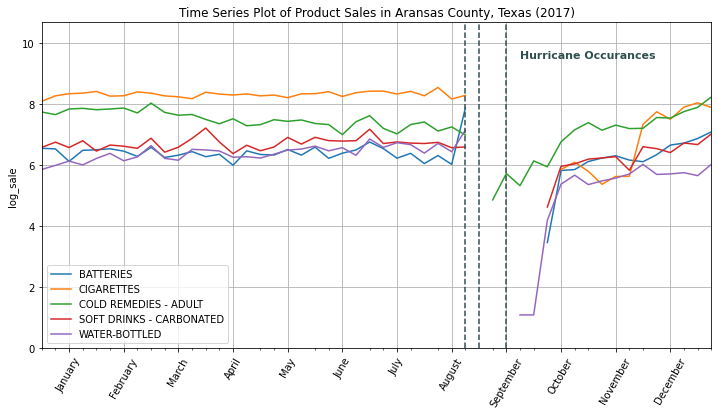

In [ ]:
plot_gb_time_series(temp2_df, 'week_end_date', 'product_module_descr', 'log_sale',
                    figsize=(12, 6), title="Time Series Plot of Product Sales in Aransas County, Texas (2017)")

